# Alexander Peltier & Gabriel Aracena

# Gene Expression and Control/Treatment

Gene expression refers to how actively a gene is being transcribed to mRNA and then translated into proteins. The expression levels of genes can vary under different conditions, such as in response to treatment or environmental changes. 

In the context of this assignment, we compare the expression of a gene under two conditions: a control condition (no treatment) and a treatment condition (where cells, for example, are exposed to a specific drug or environmental change).

# Guassian Process (GP) Relevancy

A guassian process is a non-parametric Bayesian approach to regression and classification. In the context of time series analysis (what we are doing in this assignment) GP can model the continuous underlying function that generates the observed data, which is useful for gene expression data that varies over time.

GP involves defining a prior over functions - a mean function m(x) and a covariance function k(x, x') where x and x' are two points in the input space.

For gene expression data, x represents time, and the output would be the expression level at that time.

# How Guassian Process can be used in Linear Regression

GP can generalize linear regression by allowing for infinitely many functions to fit the data - rather than assuming a specific functional form (like a line). This is especially useful for modeling non-linear trends in gene expression over time.

# Import

In [2]:
import GPy
import numpy as np
import matplotlib.pyplot as plt

# Generate Synthetic Dataset

The generated synthetic data is sinusoidal data with noise that aims to mimic periodic or cyclical behavior.

In [3]:
np.random.seed(42)
n_points = 100
times = np.linspace(0, 10, n_points)[:, None]

true_function_control = np.sin(times) + 0.5
true_function_treatment = np.sin(times) * np.cos(times * 0.5) + 1.0

observed_control = true_function_control + np.random.normal(0, 0.2, size=true_function_control.shape)
observed_treatment = true_function_treatment + np.random.normal(0, 0.2, size=true_function_treatment.shape)

# Plot Synthetic Dataset

In this dataset, we can assume that a Gene Expression Level (GEL) of -0.5 to 0 might be considered None to Low expression, whereas a Baseline GEL would be around 0, and finally a moderate to high GEL around 1.5.

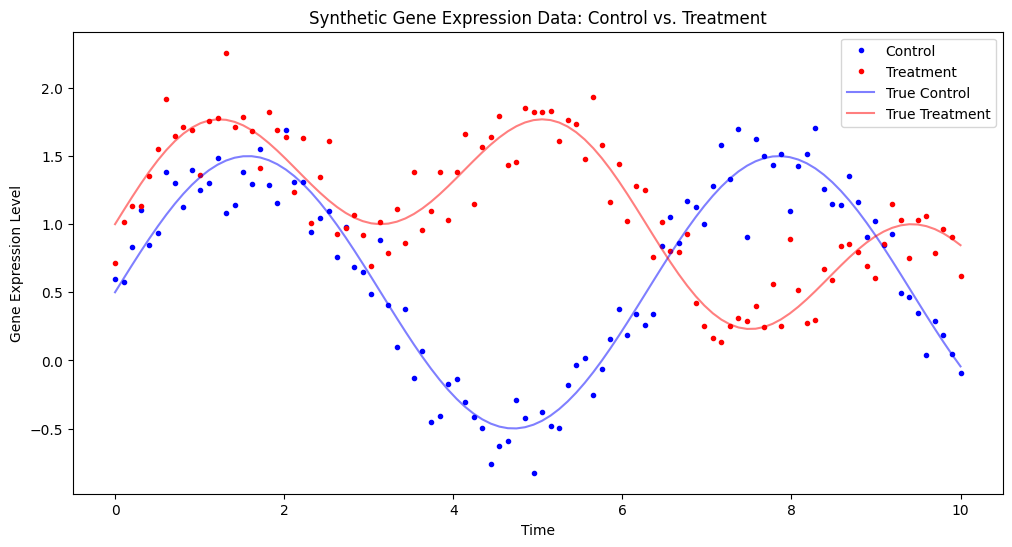

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(times, observed_control, 'b.', label='Control')
plt.plot(times, observed_treatment, 'r.', label='Treatment')
plt.plot(times, true_function_control, 'b-', alpha=0.5, label='True Control')
plt.plot(times, true_function_treatment, 'r-', alpha=0.5, label='True Treatment')
plt.xlabel('Time')
plt.ylabel('Gene Expression Level')
plt.title('Synthetic Gene Expression Data: Control vs. Treatment')
plt.legend()
plt.show()

# Define Model & Train

Define the covariance function (Radial Basis Function, RBF) and then define a GP regression model for each condition (control and treatment).

The shaded area around the mean prediction line indicates the 9% confidence intervals. If these are very wide, then it means the model is relatively uncertain about its predictions at those points - and if its narrow, the opposite.

In [5]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

model_control = GPy.models.GPRegression(times, observed_control, kernel.copy())
model_control.optimize(messages=True)

model_treatment = GPy.models.GPRegression(times, observed_treatment, kernel.copy())
model_treatment.optimize(messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0001   1.060816e+02   7.969438e+02 

    00s16  0010  -1.028196e+01   4.858822e-01 
    00s26  0019  -1.054791e+01   4.979869e-09 
Runtime:     00s26
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0004   3.898602e+01   1.142720e+03 
    00s08  0006   4.402290e+00   8.264211e+02 
    00s16  0012  -1.680396e+00   4.751212e-01 
    00s29  0019  -1.699599e+00   1.845794e-13 
Runtime:     00s29
Optimization status: Converged



# Plot Model

Plot side-by-side plots for the control and treatment conditions

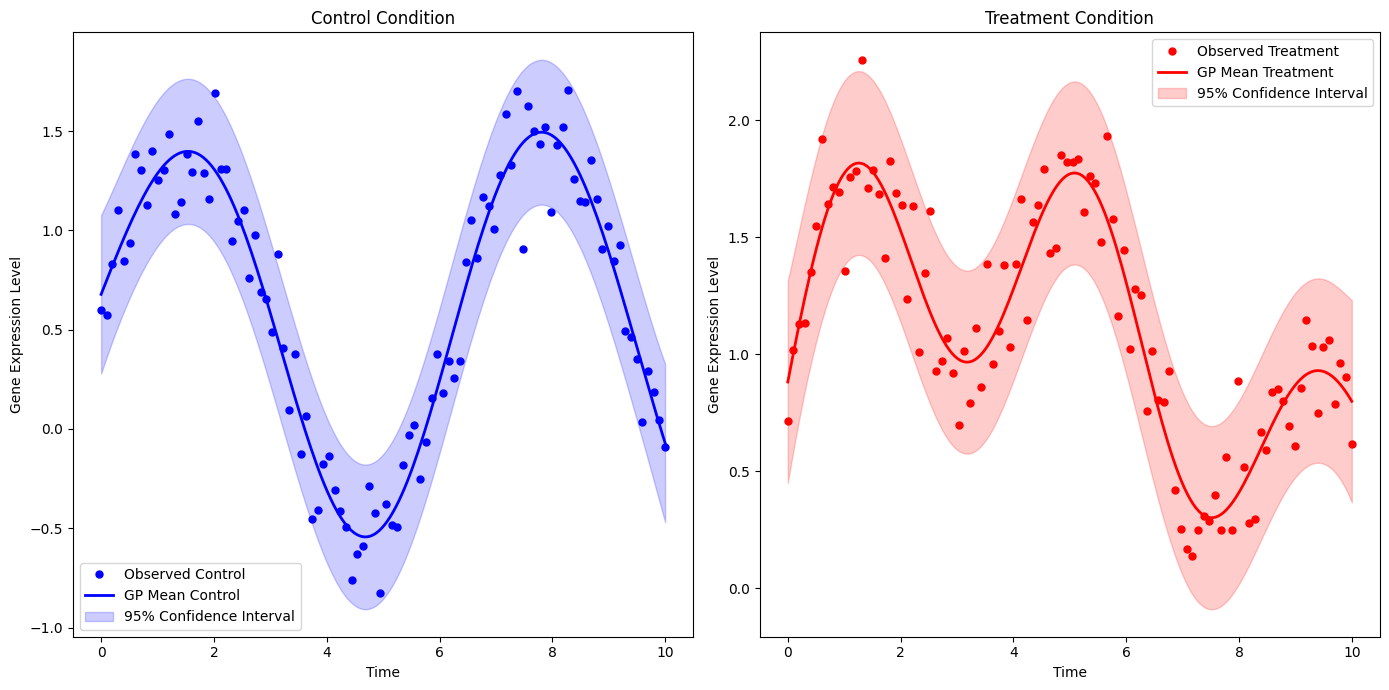

In [6]:
x_pred = np.linspace(0, 10, 200)[:, None]
y_pred_control, var_control = model_control.predict(x_pred)
y_pred_treatment, var_treatment = model_treatment.predict(x_pred)

std_dev_control = np.sqrt(var_control)
std_dev_treatment = np.sqrt(var_treatment)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(times, observed_control, 'b.', markersize=10, label='Observed Control')
plt.plot(x_pred, y_pred_control, 'b-', lw=2, label='GP Mean Control')
plt.fill_between(x_pred[:, 0], (y_pred_control - 1.96 * std_dev_control).flatten(),
                 (y_pred_control + 1.96 * std_dev_control).flatten(), color='blue', alpha=0.2, label='95% Confidence Interval')

plt.xlabel('Time')
plt.ylabel('Gene Expression Level')
plt.title('Control Condition')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(times, observed_treatment, 'r.', markersize=10, label='Observed Treatment')
plt.plot(x_pred, y_pred_treatment, 'r-', lw=2, label='GP Mean Treatment')
plt.fill_between(x_pred[:, 0], (y_pred_treatment - 1.96 * std_dev_treatment).flatten(),
                 (y_pred_treatment + 1.96 * std_dev_treatment).flatten(), color='red', alpha=0.2, label='95% Confidence Interval')

plt.xlabel('Time')
plt.ylabel('Gene Expression Level')
plt.title('Treatment Condition')
plt.legend()

plt.tight_layout()
plt.show()

## Gauissian process prior
A Gaussian process (GP) prior is a concept in Bayesian statistics and machine learning that represents a prior distribution over functions, indicating our beliefs about these functions before any data is observed. Defined by a mean function (often assumed to be zero) and a covariance function (or kernel), it dictates the characteristics of the functions, such as their smoothness and correlation between points. This non-parametric approach allows for great flexibility, enabling the incorporation of prior knowledge and providing a natural measure of uncertainty in predictions. 

## Posterior Noise-free observations

To address posterior noise-free observations and predictions with noisy observations in your notebook, we need to ensure the GP model accounts for noise explicitly. This is typically done by using a noise term in the kernel function. The WhiteKernel component of a kernel in the Gaussian Process implementation is used for this purpose, representing the noise level in the observations.

In [7]:
import GPy

# Define the RBF kernel
kernel_rbf = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

# Include a white noise kernel component by adding Gaussian noise to the model
# This is equivalent to adding a WhiteKernel in sklearn
kernel = kernel_rbf + GPy.kern.White(input_dim=1, variance=0.1)  # Adjust the variance as needed

# Create and optimize the GP model for the control group
model_control = GPy.models.GPRegression(times, observed_control, kernel.copy())
model_control.optimize(messages=True)

# Create and optimize the GP model for the treatment group
model_treatment = GPy.models.GPRegression(times, observed_treatment, kernel.copy())
model_treatment.optimize(messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.103020e+02           nan 

    00s07  0004   1.226247e+03   1.345052e+06 
    00s18  0011  -1.049864e+01   6.303672e-01 
    00s26  0018  -1.054791e+01   4.417623e-09 
Runtime:     00s26
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0003   3.712823e+00   2.221518e+02 
    00s05  0004   5.076558e+02   2.345784e+05 
    00s12  0009  -1.629731e+00   7.315184e-01 
    00s24  0018  -1.699599e+00   1.317583e-11 
Runtime:     00s24
Optimization status: Converged



## Optimization

Optimization parameters and objectives are central to the training of Gaussian Process (GP) models, especially when working with complex data such as gene expression. In the context of our GP model for gene expression analysis, optimization involves adjusting the model's hyperparameters to best fit the data. The objective of optimization is to improve the model's predictions by minimizing a loss function, which quantifies the difference between the observed data and the model's predictions. Here's how it applies to GP models:

In [11]:
## Generalized optimization
model_control.optimize(messages=True, optimizer='lbfgs', max_iters=1000)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0004  -1.054791e+01   2.151089e-10 
Runtime:     00s06
Optimization status: Converged

